### Imports

In [1]:
import torch
import os
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from natsort import natsorted
from torchvision import models
from sklearn.model_selection import train_test_split

In [2]:
BASE_FOLDER = os.getcwd()
print(BASE_FOLDER)

c:\Users\fdavi\Desktop\LymphomAug


### Creating the pytorch dataset

In [8]:
class LymphomaDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        self.image_paths = natsorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
        self.label_paths = natsorted([os.path.join(label_folder, f) for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = int(self.read_label_file(self.label_paths[idx]))

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_label_file(self, label_path):
        # Implement logic to read labels from label files
        # For example, if labels are in text files, you can use:
        with open(label_path, 'r') as file:
            label = file.read().strip()  # Adjust based on your label format
        return label

# Replace 'your_image_folder' and 'your_label_folder' with the actual paths
base_folder = os.getcwd()
train_image_folder = os.path.join(base_folder, "data", "train", "images")
train_label_folder = os.path.join(base_folder, "data", "train", "labels")
test_image_folder = os.path.join(base_folder, "data", "test", "images")
test_label_folder = os.path.join(base_folder, "data", "test", "labels")

# Define transformation (optional, you can customize it based on your needs)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Instantiate the custom dataset
train_dataset = LymphomaDataset(train_image_folder, train_label_folder, transform=transform)

batch_size =256

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


### Creating the AlexNet

In [9]:
alexnet = models.alexnet(num_classes=3)
# alexnet.eval()

### Training loop

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

alexnet.to(device) # alexnet to the device, gpu if available

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Set the model to training mode
    alexnet.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate training accuracy and loss for the epoch
    train_accuracy = correct_predictions / total_samples
    average_train_loss = running_loss / len(train_loader)

    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Training - Epoch: {epoch + 1}, Training loss: {average_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}')


True
Training - Epoch: 1, Training loss: 1.3247, Training accuracy: 0.4365
Training - Epoch: 2, Training loss: 0.9527, Training accuracy: 0.5087
Training - Epoch: 3, Training loss: 0.9176, Training accuracy: 0.4672
Training - Epoch: 4, Training loss: 0.9091, Training accuracy: 0.5111
Training - Epoch: 5, Training loss: 0.9049, Training accuracy: 0.5111
Training - Epoch: 6, Training loss: 0.9116, Training accuracy: 0.5111
Training - Epoch: 7, Training loss: 0.9076, Training accuracy: 0.5148
Training - Epoch: 8, Training loss: 0.9064, Training accuracy: 0.5172
Training - Epoch: 9, Training loss: 0.9211, Training accuracy: 0.5105
Training - Epoch: 10, Training loss: 0.9068, Training accuracy: 0.5154
Training - Epoch: 11, Training loss: 0.9088, Training accuracy: 0.5117
Training - Epoch: 12, Training loss: 0.8996, Training accuracy: 0.5111
Training - Epoch: 13, Training loss: 0.9066, Training accuracy: 0.5232
Training - Epoch: 14, Training loss: 0.9015, Training accuracy: 0.5172
Training -

KeyboardInterrupt: 

Test - Test loss: 5.1697, Test accuracy: 0.4248


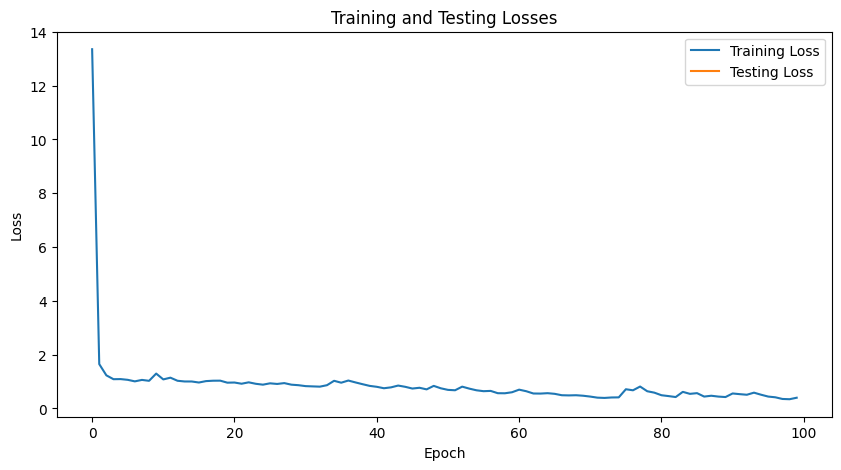

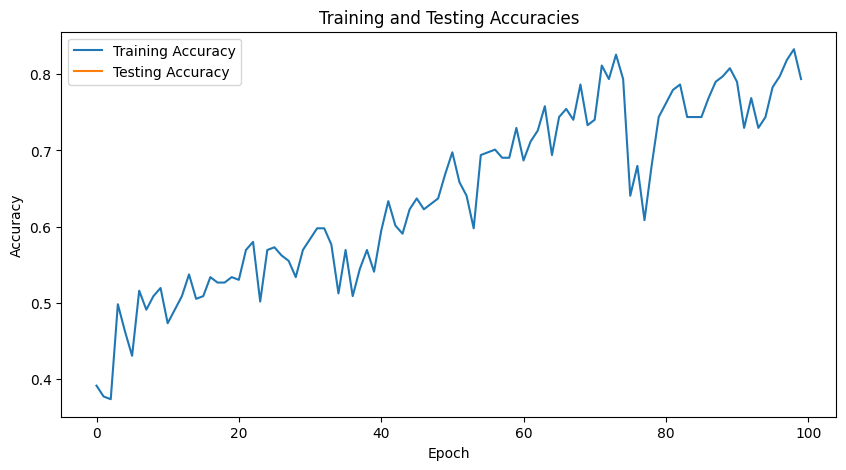

In [7]:

test_loss = 0.0
correct_predictions = 0
total_samples = 0


# Instantiate the custom dataset
test_dataset = LymphomaDataset(test_image_folder, test_label_folder, transform=transform)

batch_size = 256

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # Update running statistics
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = correct_predictions / total_samples
average_test_loss = test_loss / len(test_loader)

print(f'Test - Test loss: {average_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

test_losses.append(average_test_loss)
test_accuracies.append(test_accuracy)

# Plot training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

# Plot training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.show()